# Reviews Amazon
## Clasificación de reviews
## Grupo 2_02
### Julen Sanchez Monreal
### David Soto Arbizu
### Fermín Zubiri Remirez

### Índice
 - [Descarga de reviews](#Descarga-de-reviews)
 - [Preprocesamiento de datos](#Preprocesamiento-de-datos)
     - [Bag of Words](#Bag-of-Words)
     - [TF-IDF](#TF-IDF)
 - [Tratamiento de datos](#Tratamiento-de-datos)
 

In [2]:
pip install progressbar

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install deep-translator

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import requests
import progressbar
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from urllib.parse import urlencode

from deep_translator import GoogleTranslator

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


### Descarga de reviews

Para esta práctica hemos elegido el producto smartwatch. La razón principal es que, al ser un producto relativamente popular, hay una gran cantidad de reviews y, por tanto, podremos obtener una gran cantidad de diferentes reseñas. Para tener reviews de todas las estrellas, hemos buscado cinco smartwatch distintos porque hay algunos con muchas reviews de 1 y 2 estrellas y pocas de 4 y 5 y viceversa.
En un primer intento, únicamente descargamos las reseñas únicamente en español. Pero se nos hicieron insuficientes y tomamos la decisión de descargar reseñas en todos los idiomas y traducirlos al español.
Otra decisión a la hora de tomar los datos fue equilibrar las reseñas, es decir, darle al clasificador el mismo número de reseñas de 1,2,3,4 y 5 estrellas. De otra forma, tendería a predecir más unas estrellas que otras.
Por último en esta parte, se ha decidido eliminar todo tipo de carácteres especiales y, con ello, emoticonos. Una posible mejora del programa podría ser incluirlos ya que podrían indicar si una reseña a sido más positiva o negativa.

In [4]:
# Lista de todas las urls con todas las paginas de reseñas
list_of_urls = []
for i in range(1,145):
    list_of_urls.append("https://www.amazon.es/UMIDIGI-Urun-S-Reloj-Inteligente/product-reviews/B08QCFLKRM/ref=cm_cr_getr_d_paging_btm_prev_1?ie=UTF8&reviewerType=all_reviews&pageNumber=" + str(i))
for i in range(1,87):
    list_of_urls.append("https://www.amazon.es/UMIDIGI-Smartwatch-Inteligente-Seguimiento-Impermeable/product-reviews/B08LKQ4NH9/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=" + str(i))
for i in range(1,38):
    list_of_urls.append("https://www.amazon.es/ANSUNG-Inteligente-Smartwatch-Puls%C3%B3metro-Impermeable/product-reviews/B0B51SVNDW/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=" + str(i))
for i in range(1,382):
    list_of_urls.append("https://www.amazon.es/Smartwatch-Inteligente-Impermeable-Puls%C3%B3metro-Cron%C3%B3metros/product-reviews/B0956XD8Y7/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=" + str(i))
for i in range(1,501):
    list_of_urls.append("https://www.amazon.es/AGPTEK-Smartwatch-Inteligente-Puls%C3%B3metro-Adolescentes/product-reviews/B08TBBQ4BD/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=" + str(i))

Utilizaremos una barra de progresión y se guardarán las reseñas en un archivo csv puesto que el proceso de descarga es lento. Aunque se ha evitado usar apis de intermediarios para agilizar el proceso.

In [5]:
stars = []
reviews = []
data_string = ""
page_count = 0
bar = progressbar.ProgressBar(maxval=len(list_of_urls),
                             widgets= [progressbar.Bar('=','[',']'), ' ', progressbar.Percentage()])
bar.start()
HEADERS = ({'User-Agent':
           'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'})

for url in list_of_urls:
    response = requests.get(url, headers = HEADERS)
    soup = BeautifulSoup(response.text,"html.parser")
    
    for review in soup.find_all("div", {"data-hook": "review"}):       
#       Obtencion de la reseña, se eliminan carácteres que no aportan información
        if review.find("span",{"data-hook": "review-body"}):
            item = review.find("span",{"data-hook": "review-body"})
            data_string = data_string + item.get_text()
            data_string = data_string.replace("No se ha podido cargar el contenido multimedia.","")                            
            data_string = data_string.replace("\n","")  
            data_string = data_string.replace("\t","")  
            data_string = data_string.replace("\xa0","")  
            data_string = data_string.replace('"',"")                        
            reviews.append(data_string)
            data_string = ""
#       Obtención de las estrellas
        if review.find("i",{"data-hook": "review-star-rating"}):
            item = review.find("i",{"data-hook": "review-star-rating"})            
            data_string = data_string + item.get_text()            
            data_string = data_string[0] + "." + data_string[2]
            stars.append(data_string)
            data_string= ""
            
        elif review.find("i", {"data-hook": "cmps-review-star-rating"}):
            item = review.find("i", {"data-hook": "cmps-review-star-rating"})            
            data_string = data_string + item.get_text()            
            data_string = data_string[0] + "." + data_string[2]
            stars.append(data_string)
            data_string= "" 
    
    page_count += 1
    bar.update(page_count)
bar.finish()

[========================================================================] 100%


In [6]:
# Comprobamos que las reseñas tienen la misma longitud
print(len(reviews))
print(len(stars))

4566
4566


Creamos un diccionario con dos columnas, una de el número de estrellas y otra con la reseña

In [8]:
reviews_dict = {'Stars': stars,'Reviews': reviews}

df = pd.DataFrame.from_dict(reviews_dict, orient='index')
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565
Stars,5.0,2.0,3.0,4.0,3.0,5.0,3.0,5.0,4.0,3.0,...,3.0,5.0,4.0,4.0,5.0,5.0,2.0,5.0,1.0,1.0
Reviews,Te cuento ...,"El reloj iba perfecto (la app es una castaña ,...",La batería dura de 3 a 4 días (depende del uso...,Excelente,Muito difícil de conectar ao nosso telemóvel v...,Solo en una semana funciona muy bien!!! muy b...,Es preciosa y funciona genial tiene todo lo qu...,Funciona perfectamente,Llevo varios días utilizándolo y la verdad que...,No se vincula con app básicas,...,Die mobile App ist sehr einfach in der Bedienu...,Arrivato nei tempi previsti ottimo prodotto. D...,Muy bonito,The color is great,ottimo per qualità e prezzo,Tolle Smartwatch ist sehr einfach zu bedienen....,Ho scelto questo perché uno dei pochi in cui i...,Very impressed with how quickly it arrived. I ...,Die Uhr ist optisch wirklich sehr schön gemach...,I loved this watch for the 10 hours it actuall...


Lo trasponemos para obtener columnas con los datos que queremos

In [10]:
prod_stars = df.T
prod_stars.head(5)

,Stars,Reviews
0,5.0,Te cuento ...
1,2.0,"El reloj iba perfecto (la app es una castaña ,..."
2,3.0,La batería dura de 3 a 4 días (depende del uso...
3,4.0,Excelente
4,3.0,Muito difícil de conectar ao nosso telemóvel v...


In [11]:
# Eliminamos reviews vacías antes de igualar las reseñas
prod_stars['Reviews'].replace("",np.nan,inplace=True)
prod_stars.dropna(subset=['Reviews'],inplace=True)
prod_stars.head(5)

,Stars,Reviews
0,5.0,Te cuento ...
1,2.0,"El reloj iba perfecto (la app es una castaña ,..."
2,3.0,La batería dura de 3 a 4 días (depende del uso...
3,4.0,Excelente
4,3.0,Muito difícil de conectar ao nosso telemóvel v...


In [12]:
# La función equalizeReviews recibe como parametro el diccionario de reviews y iguala las reseñas a la
# estrella que menos reseñas tiene
def equalizeReviews(reviews):
    mini = min(reviews['Stars'].value_counts())        
    
    resultDataFrame = pd.DataFrame(data = None, columns = reviews.columns)
    
    for i in range(1,6):
        index = str(i) + '.0'        
        selected_star_reviews = reviews.loc[reviews['Stars'] == index].sample(n=mini)       
        resultDataFrame = pd.concat([resultDataFrame,selected_star_reviews], ignore_index = True)
    return resultDataFrame

In [13]:
dfFinal = equalizeReviews(prod_stars)
dfFinal

,Stars,Reviews
0,1.0,Vi consiglio su non comprarlo. All'inizio è fa...
1,1.0,No necesito grandes prestaciones en un smartwa...
2,1.0,"20 dias y dejó de funcionar, se apagó y ya no ..."
3,1.0,"Malísimo, no lo recomiendo para nada, no cuent..."
4,1.0,"Not as I think , battery ist not so good as th..."
...,...,...
1785,5.0,"Die Uhr ist absolut klasse, viel besser als ic..."
1786,5.0,This a brilliant fitness watch for the price. ...
1787,5.0,Fonction principale: principalement utilisée p...
1788,5.0,This is a ...


La funcion translateChunk recibe como parametro la columna de reviews y la traduce.
Destacamos que el deep-translate únicamente nos permite traducir trozos de menos de 5000 carácteres,
por tanto, hemos de dividir la reseña en trozos sin cortar ninguna palabra por la mitad

In [15]:
def translateChunk(text, chunkSize = 4999):
    words = text.split()    
    splitted_text = []
    aux = ""
    for word in words:        
        if (len(aux) + len(word) + 1) > chunkSize:
            splitted_text.append(aux)
            aux = ""
        aux += word + " "
    
    if len(aux) > 0:
        splitted_text.append(aux)
        
    result_string = ""
    for chunk in splitted_text:
        result_translate = GoogleTranslator(source='auto', target='es').translate(text=chunk)
        if result_translate is not None:
            result_string += result_translate
    return result_string

In [16]:
# Traducimos todas las reseñas, este es el proceso más lento de la descarga
bar = progressbar.ProgressBar(maxval=len(dfFinal['Reviews']),
                             widgets= [progressbar.Bar('=','[',']'), ' ', progressbar.Percentage()])
bar.start()
barIndex = 0
for index,row in dfFinal.iterrows():
    row['Reviews'] = translateChunk(row['Reviews'])
    barIndex += 1
    bar.update(barIndex)
    
bar.finish()

[========================================================================] 100%


In [17]:
# Volvemos a eliminar las reviews vacías por si la traducción nos ha dado un resultado vacío
dfFinal['Reviews'].replace("",np.nan,inplace=True)
dfFinal.dropna(subset=['Reviews'],inplace=True)

In [18]:
# Creamos un csv con la información obtenida
dfFinal.to_csv('reviews.csv', index=False, header=True, encoding = "utf-8-sig", sep = ';')

### Preprocesamiento de datos

En esta parte hemos decidido eliminar cualquier carácter especial, incluyendo emojis. Una posible mejora adicional del proyecto sería incluir los emojis para comprobar si afecta a su comportamiento. También hemos elegido lemmatizar ya que consideramos que, a pesar de ser mas costoso en cuanto a tiempo de ejecución, guarda mejor la esencia del significado de la palabra y para este preprocesamiento con el objetivo de clasificar textos creemos que es una mejor opción. Igualmente se podría incluir en posibles mejoras del programa.

In [19]:
# Recuperamos los datos del csv
data = pd.read_csv('reviews.csv', delimiter = ";")
data.head(5)

,Stars,Reviews
0,1.0,Te aconsejo que no lo compres. Es genial al pr...
1,1.0,No necesito grandes prestaciones en un smartwa...
2,1.0,"20 dias y dejó de funcionar, se apagó y ya no ..."
3,1.0,"Malísimo, no lo recomiendo para nada, no cuent..."
4,1.0,"No como creo, la batería no es tan buena como ..."


Vamos a crear varias funciones para tratar los datos y así obtener de cada reseña un vector con un número de características.

In [20]:
# Eliminamos las palabras que carecen de un significado relevante para la reseña
def remove_stopword(text):
    text = [word for word in text.split() if word not in stopwords.words('spanish')]    
    return ' '.join(text)

In [21]:
# Lemmatizamos las palabras, es decir, obtenemos las palabras que tienen un significado parecido en una
# única palabra
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(text)

Pretratamiento final de una review.

In [22]:
def final_preprocessor(text):
    text = text.lower()    
    text = [re.sub('[^a-zñáéíóú]+', '',word) for word in text.split()]    
    text = ' '.join(text)    
    text = remove_stopword(text)    
    text = lemmatize_text(text)        
    return text

Vamos a comprobar que el procesamiento está haciendo lo que debe con un ejemplo.

In [23]:
test_review = data['Reviews'][0]
processed_test_review = final_preprocessor(test_review)
print("Antes: ")
print(test_review)
print("Después: ")
print(processed_test_review)

Antes: 
Te aconsejo que no lo compres. Es genial al principio, realmente parece estar bien hecho. Al cabo de menos de 24 horas empezó a dar problemas, la pantalla se oscureció de repente, se apagó y, tras volver a encenderla, siempre aparecía la palabra APP en la pantalla. He intentado actualizar los recursos, el sistema y el firmware; Lo reseteé, lo reinstalé y probé de todo.Al final lo devolví, después de ni 48 horas.Es el segundo Umidigi el que me está dando problemas, ahora he cambiado de marca.
Después: 
aconsejo compres genial principio realmente parece bien hecho cabo menos horas empezó dar problemas pantalla oscureció repente apagó tras volver encenderla siempre aparecía palabra app pantalla intentado actualizar recursos sistema firmware reseteé reinstalé probé todoal final devolví después horases segundo umidigi dando problemas ahora cambiado marca


Ahora vamos a aplicar el preprocesamiento a todas las reviews.

In [24]:
data['Reviews'] = data.apply(lambda row: final_preprocessor(row[1]), axis = 1)

Dividimos los datos en entrenamiento y test. En este caso hemos elegido un 80% de datos de train y un 20% de datos de test.

In [25]:

# Creación de los conjuntos de test (10% de los ejemplos) y el resto de ejemplos
X_train, test, y_train, test_y = model_selection.train_test_split(data['Reviews'], data['Stars'], train_size=0.8, random_state=888)
# Creación de los conjuntos de train (80% de los ejemplos) y de validación (resto de los ejemplos)
X_test, X_val, y_test, y_val = model_selection.train_test_split(test, test_y, train_size=0.5, random_state=888)


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1429,)
(179,)
(179,)
(1429,)
(179,)
(179,)


#### Bag of Words

In [26]:
cv = CountVectorizer(lowercase = False,                                          
                     min_df=0.01,
                     max_df=0.7,
                     binary=False)

X_train_cv = cv.fit_transform(X_train)
print(X_train_cv.shape)
X_Val_cv = cv.transform(X_val)

(1429, 392)


#### TF-IDF

In [27]:
tfidfv = text.TfidfVectorizer(lowercase = False,
                              min_df = 0.01,
                              max_df = 0.8)
X_train_tfidfv = tfidfv.fit_transform(X_train)
print(X_train_tfidfv.shape)
X_Val_tfidfv = tfidfv.transform(X_val)

(1429, 392)


### Tratamiento de datos
En este proyecto, vamos a probar cuatro clasificadores: <br>
    &emsp;- Naive Bayes <br>
    &emsp;- Regresión Logística <br>
    &emsp;- Random Forest <br>
    &emsp;- Redes Neuronales <br>
Hemos elegido añadir Random Forest ya que es un clasificador consistente que tiene buenos resultados en general y ayuda con la reducción de variables. Por otro lado, hemos escogido Redes Neuronales ya que es intuitivo asignar una característica por perceptrón.

In [28]:
def clasifica(X_train, X_val, y_train, y_val, cf):
    np.random.seed(12)
    lr = LogisticRegression()
    nn = MLPClassifier()
    rf = RandomForestClassifier()
    nb = MultinomialNB()
    if type(cf) == type(rf):
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif type(cf) == type(lr):
        param_grid = {'penalty': ['l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [10000]}
    elif type(cf) == type(nb):
        param_grid = {
            'alpha': [0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False]
        }
    else:
        param_grid = {
            'hidden_layer_sizes': [range(1, 25, 2)],
            'activation': ['logistic', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [10000]
        }
    grid_search = GridSearchCV(estimator=cf, param_grid=param_grid, cv=5)

    grid_search.fit(X_train, y_train)
    predTrain = grid_search.predict(X_train)
    predVal = grid_search.predict(X_val)

    accTrain = metrics.accuracy_score(y_train, predTrain)
    accVal = metrics.accuracy_score(y_val, predVal)
    print("Mejores hiperparámetros:", grid_search.best_params_)
    return accTrain, accVal, predTrain, predVal


Asignamos la misma semilla para obtener resultados lo menos sesgados posible.

In [29]:
np.random.seed(12)
lr = LogisticRegression()
nn = MLPClassifier()
rf = RandomForestClassifier()
nb = MultinomialNB()

Obtenemos los mejores hiper-parámetros para este problema en el conjuto de train.

In [30]:
##Creamos un dataset para guardar los resultados
title = {'Name','AccuracyVal','AccuracyTrain'}
df = pd.DataFrame(columns = title)

[accTrain,accVal,predTrain,predVal] = clasifica(X_train_tfidfv, X_Val_tfidfv, y_train, y_val,lr)
df = df.append({'Name': 'Regresion logistica', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True)
[accTrain,accVal,predTrain,predVal] = clasifica(X_train_tfidfv, X_Val_tfidfv, y_train, y_val,nb)
df = df.append({'Name': 'Naive Bayes', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True) 
[accTrain,accVal,predTrain,predVal] = clasifica(X_train_tfidfv, X_Val_tfidfv, y_train, y_val,nn)
df = df.append({'Name': 'Redes Neuronales', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True)
[accTrain,accVal,predTrain,predVal] = clasifica(X_train_tfidfv, X_Val_tfidfv, y_train, y_val,rf)
df = df.append({'Name': 'Random Forest', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True)

Mejores hiperparámetros: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
Mejores hiperparámetros: {'alpha': 1.0, 'fit_prior': False}
Mejores hiperparámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': range(1, 25, 2), 'learning_rate': 'constant', 'max_iter': 10000, 'solver': 'adam'}
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Hacemos lo mismo para el conjunto de validación.

In [31]:
##Creamos un dataset para guardar los resultados
title = {'Name','AccuracyVal','AccuracyTrain'}
dfBag = pd.DataFrame(columns = title)

[accTrain,accVal,predTrain,predVal] = clasifica(X_train_cv, X_Val_cv, y_train, y_val,lr)
dfBag = dfBag.append({'Name': 'Regresion logistica', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True)
[accTrain,accVal,predTrain,predVal] = clasifica(X_train_cv, X_Val_cv, y_train, y_val,nb)
dfBag = dfBag.append({'Name': 'Naive Bayes', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True) 
[accTrain,accVal,predTrain,predVal] = clasifica(X_train_cv, X_Val_cv, y_train, y_val,nn)
dfBag = dfBag.append({'Name': 'Redes Neuronales', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True)
[accTrain,accVal,predTrain,predVal] = clasifica(X_train_cv, X_Val_cv, y_train, y_val,rf)
dfBag = dfBag.append({'Name': 'Random Forest', 'AccuracyVal': accVal,'AccuracyTrain': accTrain}, ignore_index=True)

Mejores hiperparámetros: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}
Mejores hiperparámetros: {'alpha': 1.0, 'fit_prior': False}
Mejores hiperparámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': range(1, 25, 2), 'learning_rate': 'constant', 'max_iter': 10000, 'solver': 'adam'}
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [32]:
print(df)
##Ahora seleccionamos el mejor y probamos a usarlo con los datos del test

   AccuracyVal  AccuracyTrain                 Name
0     0.357542       0.586424  Regresion logistica
1     0.379888       0.620714          Naive Bayes
2     0.212291       0.201540     Redes Neuronales
3     0.351955       0.895031        Random Forest


In [33]:
print(dfBag)

   AccuracyVal  AccuracyTrain                 Name
0     0.335196       0.642407  Regresion logistica
1     0.374302       0.592722          Naive Bayes
2     0.206704       0.202939     Redes Neuronales
3     0.340782       0.941218        Random Forest


In [34]:
dfBag['AccuracyVal'].max()

0.3743016759776536

Con esto vemos que el clasificador de Naive Bayes con la opción de Bag of Words es el resultado que mayor precisión tiene. Por lo tanto vamos a elegir ese modelo con los mejores hiperparametros para evaluar los datos de test

In [35]:
#predecir en test con el mejor clasificador
X_test_cv = cv.transform(X_test)
nb = MultinomialNB(alpha = 0.5, fit_prior = True)
nb.fit(X_train_cv, y_train)
predTest = nb.predict(X_test_cv)
predTrain = nb.predict(X_train_cv)                       
accTest = metrics.accuracy_score(y_test, predTest)
print("Accuracy en test",accTest)

Accuracy en test 0.44692737430167595


El resultado es bastante malo, vamos a graficar los resultados mediante una matriz de confusion y un grafico para observar en donde ha fallado.

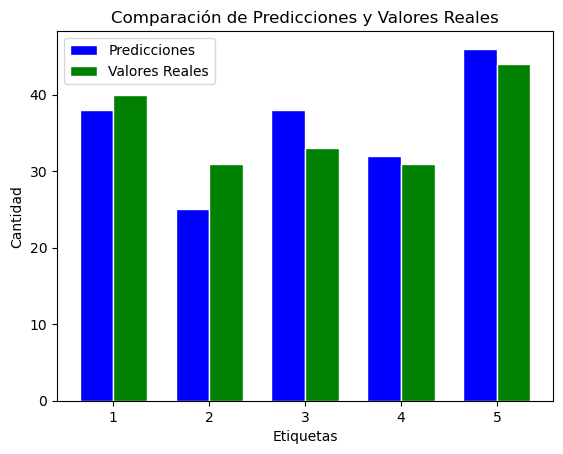

In [36]:
# Crear un DataFrame con las etiquetas reales y predichas
df = pd.DataFrame({'real': y_test, 'predicho': predTest})
labels = [1, 2, 3, 4, 5]
# Contar la cantidad de reviews en cada estrella
real_counts = df['real'].value_counts().sort_index()
predicho_counts = df['predicho'].value_counts().sort_index()

# Configurar la posición de las barras en el gráfico
bar_width = 0.35
r1 = np.arange(len(predicho_counts))
r2 = [x + bar_width for x in r1]

# Crear el gráfico de barras
plt.bar(r1, predicho_counts, color='blue', width=bar_width, edgecolor='white', label='Predicciones')
plt.bar(r2, real_counts, color='green', width=bar_width, edgecolor='white', label='Valores Reales')

# Configurar las etiquetas y los títulos del gráfico
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.xticks([r + bar_width/2 for r in range(len(predicho_counts))], labels)
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()

# Mostrar el gráfico
plt.show()

Como podemos ver, el modelo se ajusta dentro de lo que cabe, es decir, no se extremiza prediciendo constantemente una estrella o casos por el estilo. Vamos a investigar más a fondo de dónde puede provenir el error.

aciertos:  80
falla por 1:  56
falla por 2:  23
falla por 3:  15
falla por 4:  5


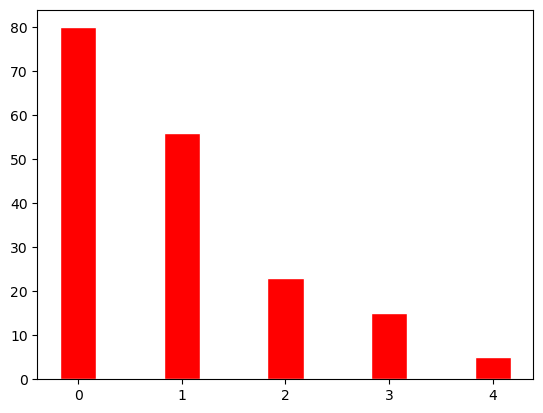

In [37]:
dif = np.array(predTest)
for i in range(predTest.size):
    #print("prediccion: {} valor Real {}".format(predTest[i],val_y[i]))
    dif[i] = abs(y_test.iloc[i]-predTest[i])
print("aciertos: ",dif[dif == 0].size)
print("falla por 1: ",dif[dif == 1].size)
print("falla por 2: ",dif[dif == 2].size)
print("falla por 3: ",dif[dif == 3].size)
print("falla por 4: ",dif[dif == 4].size)

count_dif = []
count_dif.append(dif[dif == 0].size)
count_dif.append(dif[dif == 1].size)
count_dif.append(dif[dif == 2].size)
count_dif.append(dif[dif == 3].size)
count_dif.append(dif[dif == 4].size)

plt.bar(np.arange(5), count_dif, color='red', width=bar_width, edgecolor='white', label='Predicciones' )


plt.show()

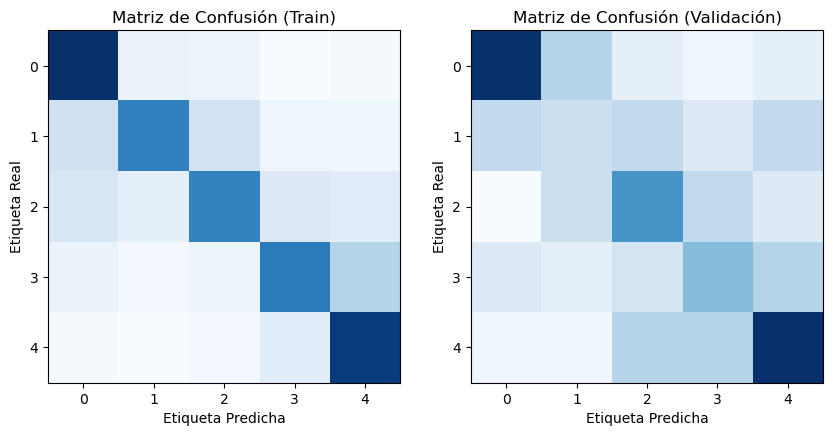

In [38]:
# Matriz de confusión para los resultados de train
cm_train = confusion_matrix(y_train, predTrain)

# Matriz de confusión para los resultados de Validacion
cm_val = confusion_matrix(y_test, predTest)

# Crear un subplot con dos gráficos de matriz de confusión
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Graficar la matriz de confusión de train en el primer gráfico del subplot
axes[0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Matriz de Confusión (Train)')
axes[0].set_xlabel('Etiqueta Predicha')
axes[0].set_ylabel('Etiqueta Real')


# Graficar la matriz de confusión de Validacion en el segundo gráfico del subplot
axes[1].imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title('Matriz de Confusión (Validación)')
axes[1].set_xlabel('Etiqueta Predicha')
axes[1].set_ylabel('Etiqueta Real')

# Mostrar el subplot
plt.show()


Como se observa en la matriz de confusión, la mayoria de los fallos son que falla en 1 estrella, siendo los mas destacados los fallos en 1 y 5 estrellas. Aunque el la prediccion de una precision bastante mala, el clasificador falla en la mayoria de las veces por una estrella, por lo que no se equivoca demasiado. Cabe destacar que en su mayoria falla en los extremos, es decir, sabe que la review es buena o mala pero se equivoca en la intensidad ya que no sabe si es 4 o 5 estrellas, pero sabe que es una de esas, lo mismo con 1 y 2 estrellas.